In [69]:
from metawars_api import *
import pandas as pd
import numpy as np
from sortedcontainers import SortedList
from tqdm import tqdm

In [64]:
from abc import ABC

class GeneticAlgorithm(ABC):
    def __init__(self):
        super().__init__()

        self.population = None
        self.population_size = None

        self.alpha_s_cur = None # current survival rate
        self.alpha_s_min = None # min survival rate
        self.alpha_s_max = None # max survival rate

        self.alpha_r_cur = None # current reproduction rate
        self.alpha_r_min = None # min reproduction rate
        self.alpha_r_max = None # max reproduction rate

        self.alpha_m_cur = None # current mutation rate
        self.alpha_m_max = None # max mutation rate
        self.alpha_m_min = None # min mutation rate


    def get_individual(self):
        raise NotImplementedError()
    
    def get_population(self):
        self.population = [self.get_individual() for i in range(self.population_size)]

    def update_rates(self, iterations, iter, function):
        self.alpha_s_cur = function(self.alpha_s_min, self.alpha_s_max, iterations, iter)
        self.alpha_r_cur = function(self.alpha_r_min, self.alpha_r_max, iterations, iter)
        self.alpha_m_cur = function(self.alpha_m_max, self.alpha_m_min, iterations, iter)

    def evaluate(self):
        raise NotImplementedError()
    
    def reproduce(self, x, y):
        raise NotImplementedError()
    
    def mutate(self, x):
        raise NotImplementedError()
    
    def solve(self, iters: int, population_size: int, alpha_s_min: float, alpha_s_max: float, alpha_r_min: float, alpha_r_max: float, alpha_m_min: float, alpha_m_max: float, function):
        
        # set parameters for execution
        self.population_size = population_size

        self.alpha_s_cur = alpha_s_min 
        self.alpha_s_max = alpha_s_max
        self.alpha_s_min = alpha_s_min

        self.alpha_r_cur = alpha_r_min
        self.alpha_r_max = alpha_r_max 
        self.alpha_r_min = alpha_r_min

        self.alpha_m_cur = alpha_m_max
        self.alpha_m_min = alpha_m_min
        self.alpha_m_max = alpha_m_max 

        self.get_population()


        for i in tqdm(range(iters)):

            evaluation = self.evaluate()
            sorted_individuals = [x[1] for x in sorted(enumerate(self.population), key=lambda x: evaluation[x[0]], reverse=True)] # high is better
            
            survivors_count = int(self.population_size * self.alpha_s_cur)
            offspring_count = int(self.population_size * self.alpha_r_cur)
            mutation_count = int(self.population_size * self.alpha_m_cur)

            survivors = sorted_individuals[:survivors_count]

            parents = sorted_individuals[:offspring_count] # parents will be the top % of the population
            offspring = [self.reproduce(random.choice(parents), random.choice(parents)) for i in range(offspring_count)]
            
            mutations = [self.mutate(x) for x in random.sample(sorted_individuals, mutation_count)]

            remaining_count = self.population_size - survivors_count - offspring_count - mutation_count
            randoms = [self.get_individual() for i in range(remaining_count)]

            self.population = survivors + offspring + mutations + randoms

            self.update_rates(iters, i+1, function)

            print("=====================")
            print(self.alpha_s_cur)
            print(self.alpha_r_cur)
            print(self.alpha_m_cur)
            print("=====================")


        evaluation = self.evaluate()
        return list(zip(self.population, evaluation))


In [65]:
class ArmyGeneticAlgorithm(GeneticAlgorithm):
    
    def get_individual(self):
        budget = self.army_budget
        army = []

        while budget > 0:
            limit = self.units_by_cost.bisect_key_right(budget) - 1 # get the index of the most expensive unit cheaper than cost
            
            if (limit < 0): 
                return army
            
            sel = random.randint(0, limit)
            
            unit = self.units_by_cost[sel][2]
            unit.id = self.units_by_cost[sel][0]

            budget -= unit.cost
            army.append(unit)

        if (army_cost(army) > 100000):
            raise ValueError("get-individual error")

        return army
    

    def evaluate(self):
        armies = self.population
        results = np.zeros(self.population_size)

        with tqdm(total=self.population_size * (self.population_size - 1) / 2, desc="Evaluation", colour='green') as pbar:
            for i in range(len(armies)):
                for j in range(i+1, len(armies)):

                    for a,b in [(i,j), (j,i)]:
                        res = simulation(armies[a], armies[b], False)
                        
                        if (res[0] > res[1]):
                            results[a] += 1
                        else:
                            results[b] += 1
                        
                    pbar.update(1)

        return results


    def reproduce(self, x, y):
        cost = int(self.army_budget / 2  + self.army_budget / 2 * random.random())
        new_army = []
        
        for u in random.sample(x, len(x)):
            if (u.cost <= cost):
                new_army.append(u)
                cost -= u.cost
        
        cost = self.army_budget - army_cost(new_army)
        
        for u in random.sample(y, len(y)):
            if (u.cost <= cost):
                new_army.append(u)
                cost -= u.cost

        if (army_cost(new_army) > 100000):
            raise TypeError("from reproduce")

        return new_army     
    
    def mutate(self, army):
        army = army.copy()
        if random.random() <= 0.5:
            for i in range(3):
                j, k = np.random.randint(0,len(army)-1),np.random.randint(0,len(army)-1)
                army[j], army[k] = army[k], army[j]
        else:
            budget = self.army_budget - army_cost(army)
            for i in range(3):
                j = np.random.randint(0, len(army)-1)
                budget += army[j].cost
                limit = self.units_by_cost.bisect_key_right(budget) - 1
                if (limit >= 0):
                    army[j] = self.units_by_cost[limit][2]
                budget -= army[j].cost

        if (army_cost(army) > 100000):
            raise TypeError("from mutate")    
        return army
    
    def solve(self, level: int, army_budget: int, iters: int, population_size: int, alpha_s_min: float, alpha_s_max: float, alpha_r_min: float, alpha_r_max: float, alpha_m_min: float, alpha_m_max: float, function):
        
        self.army_budget = army_budget

        unit_types = ["peasant", "swordman", "spearman", "archer", "defender", "horseman", "sniper", "knight", "elefant"]
        equipment_types = ["wood", "steel", "diamond"]

        units = []
        c = 1
        for ut in unit_types:
            for wt in equipment_types:
                for at in equipment_types:
                    for l in range(1,level+1):
                        u = Unit(ut, wt, at, l)
                        if (u.cost) > army_budget:
                            break
                        units.append((c, u.cost, u, u.unit_type))
                        c =  c + 1
        
        self.units_by_cost = SortedList(units, key=lambda x: x[1])
        
        super().solve(iters, population_size, alpha_s_min, alpha_s_max, alpha_r_min, alpha_r_max, alpha_m_min, alpha_m_max, function)

In [109]:
expo_decay = lambda xmin, xmax, iterations, iter: xmin + (xmax - xmin) * (1.02 ** iter - 1) / (1.02 ** iterations - 1)
linear_update = lambda xmin, xmax, iterations, iter: xmin + (xmax - xmin) * (iter - 1) / (iterations - 1)

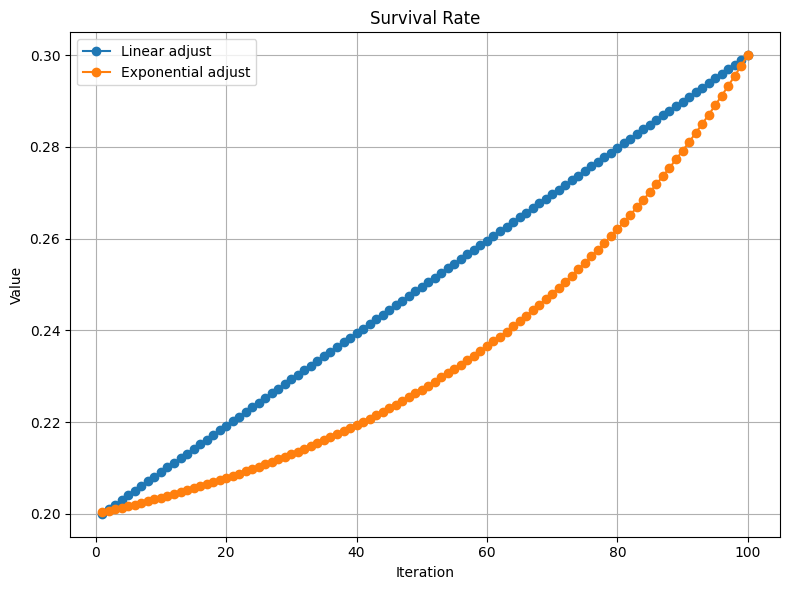

In [137]:

import matplotlib.pyplot as plt

iterations = 100

plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)
plt.plot(range(1, iterations+1), [linear_update(0.2,0.3,100,i) for i in range(1,iterations+1)], marker='o', label='Linear growth')
plt.plot(range(1, iterations+1), [expo_decay(0.2,0.3,100,i) for i in range(1,iterations+1)], marker='o', label='Exponential growth')
plt.title("Growth")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.legend()

# # Plot gradients
# plt.subplot(1, 3, 2)
# plt.plot(range(1, iterations+1), [linear_update(0.4,0.5,100,i) for i in range(1,iterations+1)], marker='o', label='Linear adjust')
# plt.plot(range(1, iterations+1), [expo_decay(0.4,0.5,100,i) for i in range(1,iterations+1)], marker='o', label='Exponential adjust')
# plt.title("Reproduction Rate")
# plt.xlabel("Iteration")
# plt.ylabel("Gradient")
# plt.grid(True)
# plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, iterations+1), [linear_update(0.2,0.1,100,i) for i in range(1,iterations+1)], marker='o', label='Linear decay')
plt.plot(range(1, iterations+1), [expo_decay(0.2,0.1,100,i) for i in range(1,iterations+1)], marker='o', label='Exponential decay')
plt.title("Decay")
plt.xlabel("Iteration")
plt.ylabel("Gradient")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
model = ArmyGeneticAlgorithm()

In [73]:
# x_min + (x_max - x_min) * (r**n - 1) / (r**iterations - 1)

In [ ]:
res = model.solve(level=10000, army_budget=100000, iters=100, population_size=100, alpha_s_min=0.2, alpha_s_max=0.3, alpha_r_min=0.4, alpha_r_max=0.5, alpha_m_min=0.1, alpha_m_max=0.2, function=expo_decay)

In [100]:
for i in range(1,101):
    print(linear_update(0.2,0.3,100,i))

0.2
0.20101010101010103
0.20202020202020204
0.20303030303030303
0.20404040404040405
0.20505050505050507
0.20606060606060608
0.20707070707070707
0.2080808080808081
0.2090909090909091
0.21010101010101012
0.2111111111111111
0.21212121212121213
0.21313131313131314
0.21414141414141416
0.21515151515151515
0.21616161616161617
0.21717171717171718
0.2181818181818182
0.2191919191919192
0.2202020202020202
0.22121212121212122
0.22222222222222224
0.22323232323232323
0.22424242424242424
0.22525252525252526
0.22626262626262628
0.22727272727272727
0.22828282828282828
0.2292929292929293
0.23030303030303031
0.2313131313131313
0.23232323232323232
0.23333333333333334
0.23434343434343435
0.23535353535353537
0.23636363636363636
0.23737373737373738
0.2383838383838384
0.23939393939393938
0.2404040404040404
0.24141414141414141
0.24242424242424243
0.24343434343434345
0.24444444444444444
0.24545454545454545
0.24646464646464647
0.2474747474747475
0.24848484848484848
0.2494949494949495
0.2505050505050505
0.2515151